# Classification

In [1]:
from util import get_train_dataset, get_features
from sklearn.ensemble import RandomForestClassifier

df = get_train_dataset()
x = get_features(df) # contains both alfa and beta features
y = df['reaction']

n_trees = 200

clf = RandomForestClassifier(n_estimators=n_trees, random_state=42, class_weight='balanced', verbose=1)

In [2]:
x.head()

,beta_J,beta_J=TRBJ1-1,beta_J=TRBJ1-1*01,beta_J=TRBJ1-2,beta_J=TRBJ1-2*01,beta_J=TRBJ1-3,beta_J=TRBJ1-3*01,beta_J=TRBJ1-4,beta_J=TRBJ1-4*01,beta_J=TRBJ1-5,...,alfa_pos_8_pI,alfa_pos_0_pI,alfa_pos_-9_pI,alfa_pos_9_pI,alfa_pos_-10_pI,alfa_pos_10_pI,alfa_pos_-11_pI,alfa_pos_11_pI,alfa_pos_-12_pI,alfa_pos_12_pI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,6.012207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,6.012207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Search all NaN's in x
import numpy as np
np.sum(np.isnan(x)) # A lot more nan's in alfa (since there is more missing data)
# just use 0 for now
x = x.fillna(0)
assert sum(np.sum(np.isnan(x))) == 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

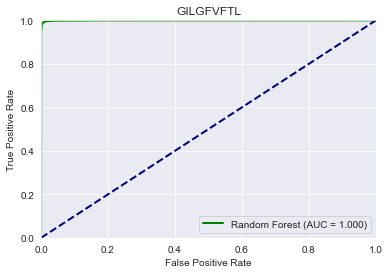

ROC AUC: 0.9995922091367182


In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

def get_training_data_roc_cv(clf, x, y):
    # ROC curve  on the training data
    predictions_rf = cross_val_predict(clf,x,y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = metrics.roc_curve(y,predictions_rf[:,1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='green',
      lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("GILGFVFTL")
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC AUC: {roc_auc}")

get_training_data_roc_cv(clf, x, y)

This doesn't seem correct... Let's take a look at the most important features

In [4]:
clf_fitted = clf.fit(x, y) # takes about 3.8 minutes

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished


In [5]:
# Get the most important features
importances = clf_fitted.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(x.shape[1])[0:10]:
    feature_index = indices[f]
    feature_name = x.columns[feature_index]
    print(f"{f+1}. feature {feature_index}: {feature_name} ({importances[feature_index]})" )

Feature ranking:
1. feature 57: beta_V=TRBV19*01 (0.08862042354957551)
2. feature 26: beta_J=TRBJ2-7*01 (0.04458626892897403)
3. feature 13: beta_J=TRBJ2-1 (0.03345992603380209)
4. feature 14: beta_J=TRBJ2-1*01 (0.03283083244164982)
5. feature 130: beta_CDR3_length (0.025865975169020054)
6. feature 155: beta_peptide_mass (0.023742822738472034)
7. feature 25: beta_J=TRBJ2-7 (0.021023058177938314)
8. feature 18: beta_J=TRBJ2-3*01 (0.01852154007604858)
9. feature 2: beta_J=TRBJ1-1*01 (0.01476732455691582)
10. feature 743: alfa_J=TRAJ42*01 (0.014409235450937374)


In [10]:
# Test data
from util import get_test_dataset
df_test = get_test_dataset()
x_test = get_features(df_test, test=True)
x_test = x_test.fillna(0)
y_test = df_test['reaction']

In [11]:
# add all columns that are in x to x_test (and fill them with 0's if they weren't in x_test)
for col in x.columns:
    if col not in x_test.columns:
        x_test[col] = 0
# remove all columns from x_test that are not in x
x_test = x_test[x.columns]

# make sure they both have the same number of features
assert x.shape[1] == x_test.shape[1]

C:\Users\arnod\AppData\Local\Temp/ipykernel_13228/2922820501.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


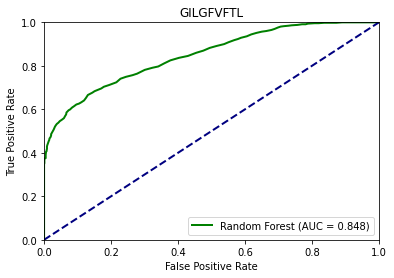

ROC AUC: 0.8476845541120724
[[998  49]
 [468 562]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

# ROC curve on the test data
predictions_rf = clf_fitted.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,predictions_rf[:,1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Note: code below is entirely from copilo
plt.figure()
plt.plot(fpr, tpr, color='green',
  lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("GILGFVFTL")
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")

# Also print the confusion matrix
y_pred = clf_fitted.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))